# 학습 개선방향

### 데이터 
- `04_011_FE.ipynb`에서 전처리 방식을 변경해가며 모델 성능에 미치는 영향을 확인

### 학습
- `item_cnt_month` 로그 변환하여 학습 -> 로컬cv 점수는 개선되었으나 LB 점수 하락
- 검증셋 구성을 위한 date_block_num 에 대한 실험
    1. 11월은 계절성이 강한 반면, 10월은 평범함. 신학기 준비로 매출이 높은 편인 9월의 판매량을 예측하는 것으로 검증전략을 강화
    2. date_block_num >= 3, date_block_num >=12, date_block_num >= 20 등 데이터 구성 변경하여 시도
        - case 1: 초기 데이터는 노이즈이고 최신 트렌드가 중요하므로 초기 데이터 제거를 통해 데이터의 질적 향상
        - case 2: 장기간 데이터를 통해 모델이 과거 패턴을 학습할 수 있고, 더 많은 데이터를 통해 모델의 일반화 성능 향상



# Module

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation

%matplotlib inline
plt.style.use("seaborn-v0_8-white")

# Data

In [ ]:
data_path = "./data/"

all_data = joblib.load(data_path + 'all_data1.joblib')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')
all_data.shape, test.shape, submission.shape

((5459310, 73), (214200, 3), (214200, 2))

In [3]:
sorted([col for col in all_data.columns if 'item_name_svd_' not in col])

['city',
 'city_avg_date_sales_lag_1',
 'city_item_category_avg_date_sales_lag_1',
 'date_block_num',
 'date_item_avg_price_lag_1',
 'date_item_avg_price_lag_12',
 'date_item_avg_price_lag_2',
 'date_item_avg_price_lag_3',
 'days',
 'delta_price_lag',
 'delta_shop_revenue_lag',
 'is_new_on_shelf',
 'item_age',
 'item_avg_date_sales_lag_1',
 'item_avg_date_sales_lag_2',
 'item_avg_price_expanding',
 'item_category_avg_date_sales_lag_1',
 'item_category_id',
 'item_cnt_month',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_12',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_id',
 'item_shop_age',
 'item_shop_first_sale',
 'items_per_transaction_lag_1',
 'month',
 'new_item',
 'num_weekends',
 'rolling_3m_cnt_mean',
 'rolling_3m_cnt_std',
 'rolling_3m_item_mean',
 'rolling_3m_item_std',
 'rolling_3m_price_mean',
 'rolling_3m_price_std',
 'rolling_6m_cnt_mean',
 'rolling_6m_cnt_std',
 'rolling_6m_item_mean',
 'rolling_6m_item_std',
 'rolling_6m_price_mean',
 'rolling_6m_price_std'

# Experiment

In [4]:
# le_weekends = LabelEncoder()
# all_data['num_weekends'] = le_weekends.fit_transform(all_data['num_weekends'])

# le_days = LabelEncoder()
# all_data['days'] = le_days.fit_transform(all_data['days'])

# Model

## prepare

-----

In [ ]:
# all_data = all_data[all_data['date_block_num']>=12] # 최신 경향 반영을 위해 오래된 데이터 제거

drop_cols = ['item_cnt_month',] 
train_mask = all_data['date_block_num'] < 33
x_train = all_data.loc[train_mask].drop(drop_cols, axis=1)

val_mask = all_data['date_block_num'] == 33
x_val = all_data.loc[val_mask].drop(drop_cols, axis=1)

y_train = all_data.loc[train_mask, 'item_cnt_month'].clip(0, 20)
y_val = all_data.loc[val_mask, 'item_cnt_month'].clip(0, 20)

all_mask = all_data['date_block_num'] <= 33
x_all = all_data.loc[all_mask].drop(drop_cols, axis=1)
y_all = all_data.loc[all_mask, 'item_cnt_month'].clip(0, 20)

test_mask = all_data['date_block_num'] == 34
x_test = all_data.loc[test_mask].drop(drop_cols, axis=1)

In [6]:
# fig, ax = plt.subplots(nrows=2, ncols=2)
# fig.set_size_inches(12, 5)

# axes = ax.flatten()
# log_yall = np.log1p(y_all)

# sns.histplot(data=y_all, kde=False, ax=axes[0])
# sns.histplot(data=log_yall, kde=False, ax=axes[1])
# sns.boxplot(x=y_all, ax=axes[2])
# sns.boxplot(x=log_yall, ax=axes[3])
# axes[0].set_title('Distribution of target variable')
# axes[1].set_title('Distribution of log-transformed target variable')
# axes[2].set_title('Boxplot of target variable')
# axes[3].set_title('Boxplot of log-transformed target variable')
# plt.tight_layout()
# plt.show()

In [7]:
# log_ytrain = np.log1p(y_train)
# log_yval = np.log1p(y_val)
# log_yall = np.log1p(y_all)

In [8]:
cat_features = ['shop_id', 'subtype', 'item_category_id', 'city', 'month', 'season_type', \
    'new_item', 'type', 'shop_type', 'is_new_on_shelf']
# dtrain = lgb.Dataset(x_train, log_ytrain, categorical_feature=cat_features)
# dval = lgb.Dataset(x_val, log_yval, categorical_feature=cat_features, reference=dtrain)
dtrain = lgb.Dataset(x_train, y_train, categorical_feature=cat_features)
dval = lgb.Dataset(x_val, y_val, categorical_feature=cat_features, reference=dtrain)

## validation

In [9]:
best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1,
    'learning_rate': 0.02,
    'feature_fraction' : 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'num_leaves' : 50, # 284 -> 100. 과적합 방지
    'min_child_samples' : 20, 
}

In [10]:
%%time
val_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain,
    num_boost_round=5000,
    valid_sets=[dval],
    valid_names=['eval'],
    callbacks=[
        log_evaluation(period=100),
        early_stopping(stopping_rounds=200, verbose=False)
    ]
)

[100]	eval's rmse: 0.782628
[200]	eval's rmse: 0.771388
[300]	eval's rmse: 0.768762
[400]	eval's rmse: 0.76714
[500]	eval's rmse: 0.767391
[600]	eval's rmse: 0.766848
[700]	eval's rmse: 0.766093
[800]	eval's rmse: 0.765548
[900]	eval's rmse: 0.765132
[1000]	eval's rmse: 0.764802
[1100]	eval's rmse: 0.765124
[1200]	eval's rmse: 0.763375
[1300]	eval's rmse: 0.761969
[1400]	eval's rmse: 0.761905
[1500]	eval's rmse: 0.761358
[1600]	eval's rmse: 0.760983
[1700]	eval's rmse: 0.760767
[1800]	eval's rmse: 0.760754
[1900]	eval's rmse: 0.760719
[2000]	eval's rmse: 0.760342
[2100]	eval's rmse: 0.759626
[2200]	eval's rmse: 0.759034
[2300]	eval's rmse: 0.758784
[2400]	eval's rmse: 0.758613
[2500]	eval's rmse: 0.758657
[2600]	eval's rmse: 0.758332
[2700]	eval's rmse: 0.758074
[2800]	eval's rmse: 0.757984
[2900]	eval's rmse: 0.758058
CPU times: user 49min 36s, sys: 6.2 s, total: 49min 42s
Wall time: 13min 37s


In [11]:
print('Best score: ', val_lgbm_model.best_score['eval']['rmse'])
print('Best iteration: ', val_lgbm_model.best_iteration)

Best score:  0.7578127445838881
Best iteration:  2749


## Experiment Log
- date_block_num>=12, Base
- Best score:  0.7730156937495843
- Best iteration:  3908
- LB : 0.92532
---
- city 전처리 개선
- Best score:  0.7694898610338219
- Best iteration: 2166
- LB : 0.92198
---
- date_block_num>=20을 실험해봤지만 로컬스코어와 LB 모두 크게 하락
- date_block_num>=3데이터로 시도
- Best score:  0.7580787674646694
- Best iteration:  3651
- LB : 0.92883
- cv는 0.01이상 크게 향상되었으나 LB는 오히려 악화되었음
---
- 다시 date_block_num>=12로 시도. 학습속도 향상위해 LR : 0.01 -> 0.02
- 'shop_revenue_share' 결측치 120만개. 0으로 대체. 결측치 처리 전, 중요도 하위 10위권
- Best score:  0.7677302079032164
- Best iteration:  3117
---
- rolling_6m 추가, item_per_transaction 추가, tf-idf=20, rolling_3m_item, item_shop_age
- Best score:  0.7066008569066063
- Best iteration:  1177
- LB : 0.99455
- 데이터 누수 의심
---
- item_shop_age 데이터 누수 수정
- Best score:  0.7696785136537013
- Best iteration:  246
- LB : 0.92697
---
- 'is_new_on_shelf' 범주형 변수 지정(이전 시도에 cat_features 누락) / tf-idf 20
- Best score:  0.7578127445838881
- Best iteration:  2749
- LB : 0.92060
--- 
- num_weekends, days를 범주형 변수로 지정 -> cv 하락. 수치형 취급
- Best score:  0.7595140309163178
- Best iteration:  1510

In [12]:
# pred_log_val = val_lgbm_model.predict(x_val, num_iteration=val_lgbm_model.best_iteration)
# pred_real_val = np.expm1(pred_log_val).clip(0, 20)

# real_rmse = np.sqrt(mean_squared_error(y_val, pred_real_val)) 

# print(f"Log Scale RMSE : {val_lgbm_model.best_score['eval']['rmse']}")
# print(f"Real Scale RMSE : {real_rmse:.4f}")

/tmp/ipykernel_23366/2734873670.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')


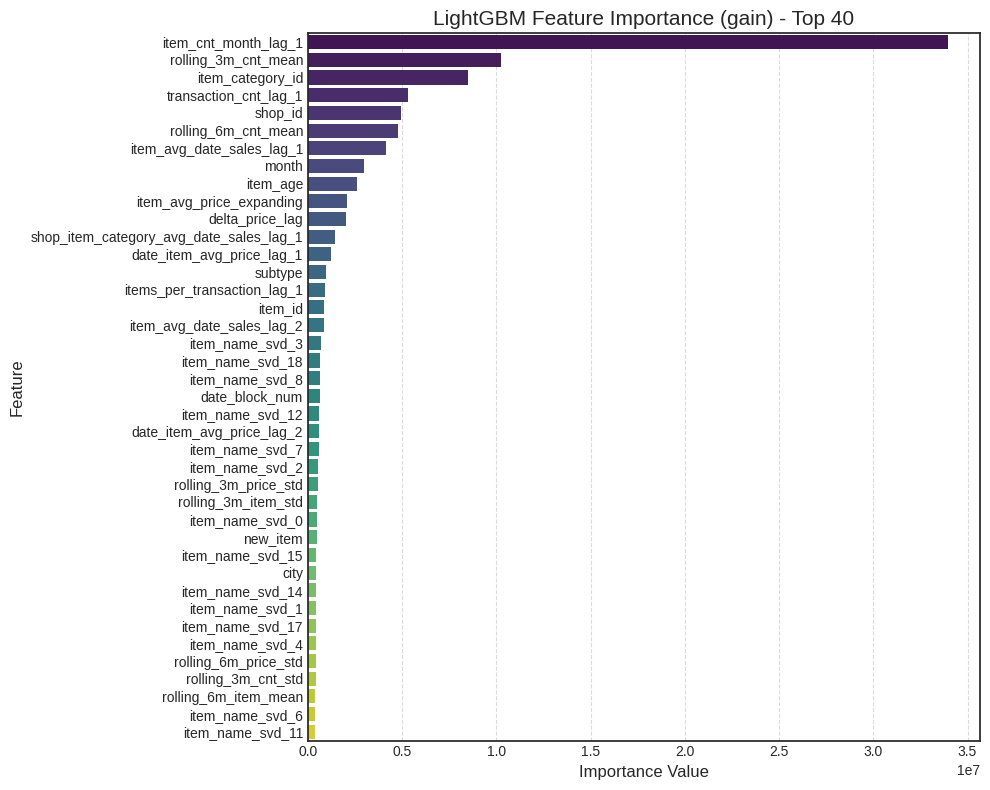

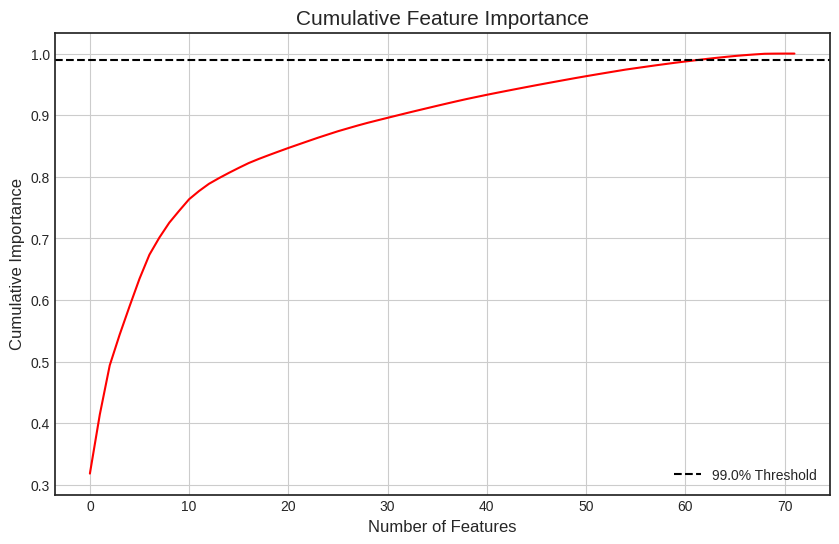

[GAIN] 분석 결과:
- 전체 피처 수: 72
- 99.0% 중요도를 설명하는 피처 수: 63
- 제거 추천 피처 수: 9
Low importance features :  ['city_avg_date_sales_lag_1', 'item_cnt_month_lag_12', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'num_weekends', 'days', 'shop_type', 'type', 'is_new_on_shelf']


In [13]:
def analyze_and_filter_features(model, importance_type='gain', cum_threshold=0.99):
    if isinstance(model, lgb.Booster):
        importance = model.feature_importance(importance_type=importance_type)
        feature_names = model.feature_name()
    else:
        importance = model.booster_.feature_importance(importance_type=importance_type)
        feature_names = model.booster_.feature_name()
        
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    feature_imp['normalized_importance'] = feature_imp['importance'] / feature_imp['importance'].sum()
    feature_imp['cumulative_importance'] = feature_imp['normalized_importance'].cumsum()
    

    plt.figure(figsize=(10, 8))    
    sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')
    plt.title(f'LightGBM Feature Importance ({importance_type}) - Top 40', fontsize=15)
    plt.xlabel('Importance Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(feature_imp.index, feature_imp['cumulative_importance'], 'r-')
    plt.axhline(y=cum_threshold, color='k', linestyle='--', label=f'{cum_threshold*100}% Threshold')
    plt.title('Cumulative Feature Importance', fontsize=15)
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Cumulative Importance', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    cutoff_index = feature_imp[feature_imp['cumulative_importance'] > cum_threshold].index[0]
    selected_features = feature_imp.loc[:cutoff_index, 'feature'].tolist()
    removed_features = feature_imp.loc[cutoff_index+1:, 'feature'].tolist()
    
    print(f"[{importance_type.upper()}] 분석 결과:")
    print(f"- 전체 피처 수: {len(feature_imp)}")
    print(f"- {cum_threshold*100}% 중요도를 설명하는 피처 수: {len(selected_features)}")
    print(f"- 제거 추천 피처 수: {len(removed_features)}")
    
    return feature_imp, selected_features, removed_features

df_imp, keep_cols, low_cols = analyze_and_filter_features(val_lgbm_model, importance_type='gain', cum_threshold=0.99)
print('Low importance features : ', low_cols)

## train

In [15]:
dtrain_all = lgb.Dataset(x_all, y_all, categorical_feature=cat_features)
# dtrain_all = lgb.Dataset(x_all, log_yall, categorical_feature=cat_features)
final_iter = int(val_lgbm_model.best_iteration * 1.1)

In [16]:
# %%time
# seed_full = [42, 1347, 2025]
# model_list = []

# for i, seed in enumerate(seed_full):
#     curr_params = best_params.copy()
#     curr_params['random_state'] = seed
#     print(f"\n[Training Model {i+1}/{len(seed_full)}] Seed: {seed}")
#     final_lgbm_model = lgb.train(
#         params=curr_params,
#         train_set=dtrain_all,
#         num_boost_round=final_iter,
#         valid_sets=[dtrain_all],
#         callbacks=[
#             log_evaluation(period=100)
#         ]
#     )
    
#     file_name = f'05_07_lgbm_model_seed_{seed}.txt'    
#     final_lgbm_model.save_model(data_path + file_name)
#     model_list.append(final_lgbm_model)

In [17]:
%%time
final_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain_all,
    num_boost_round=final_iter,
    valid_sets=[dtrain_all],
    callbacks=[
        log_evaluation(period=100)
    ]
)

file_name = f'lgbm_model_seed.txt'
final_lgbm_model.save_model(data_path + file_name)

[100]	training's rmse: 0.806178
[200]	training's rmse: 0.759081
[300]	training's rmse: 0.739646
[400]	training's rmse: 0.727228
[500]	training's rmse: 0.718423
[600]	training's rmse: 0.710624
[700]	training's rmse: 0.70229
[800]	training's rmse: 0.696786
[900]	training's rmse: 0.690381
[1000]	training's rmse: 0.68567
[1100]	training's rmse: 0.680749
[1200]	training's rmse: 0.676317
[1300]	training's rmse: 0.672608
[1400]	training's rmse: 0.669041
[1500]	training's rmse: 0.665189
[1600]	training's rmse: 0.662155
[1700]	training's rmse: 0.65898
[1800]	training's rmse: 0.656118
[1900]	training's rmse: 0.65286
[2000]	training's rmse: 0.649998
[2100]	training's rmse: 0.647345
[2200]	training's rmse: 0.645019
[2300]	training's rmse: 0.642759
[2400]	training's rmse: 0.640503
[2500]	training's rmse: 0.637797
[2600]	training's rmse: 0.635586
[2700]	training's rmse: 0.633435
[2800]	training's rmse: 0.63112
[2900]	training's rmse: 0.62905
[3000]	training's rmse: 0.627023
CPU times: user 53min 6s,

/tmp/ipykernel_13364/2734873670.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_imp.head(40), palette='viridis')


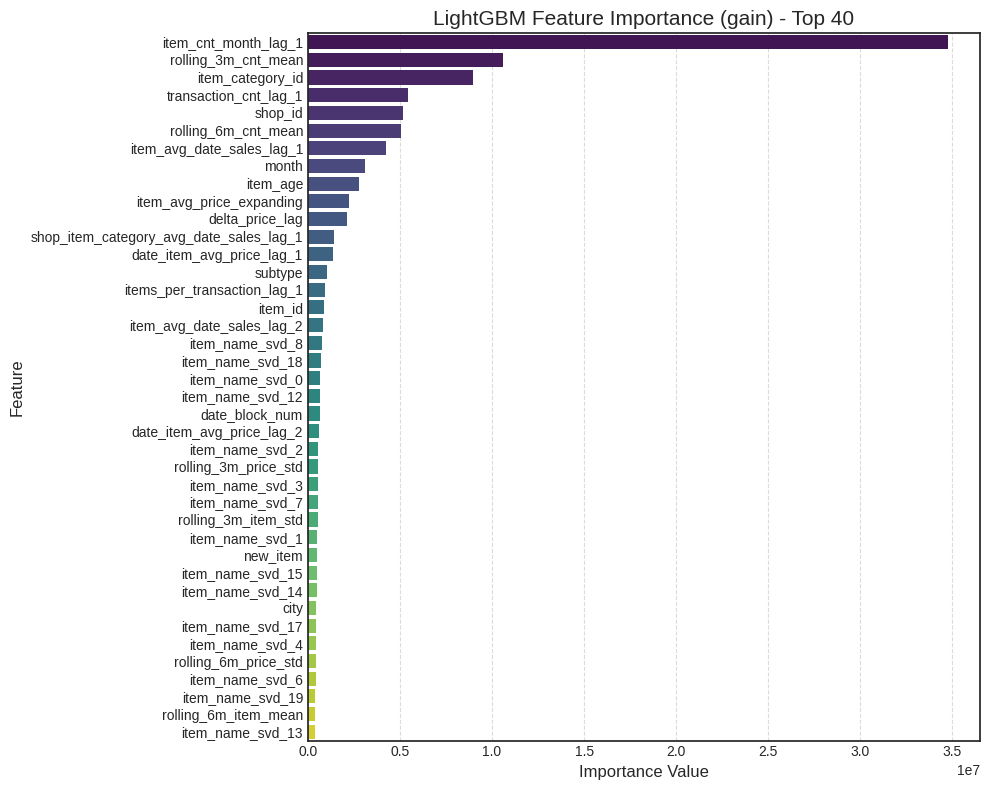

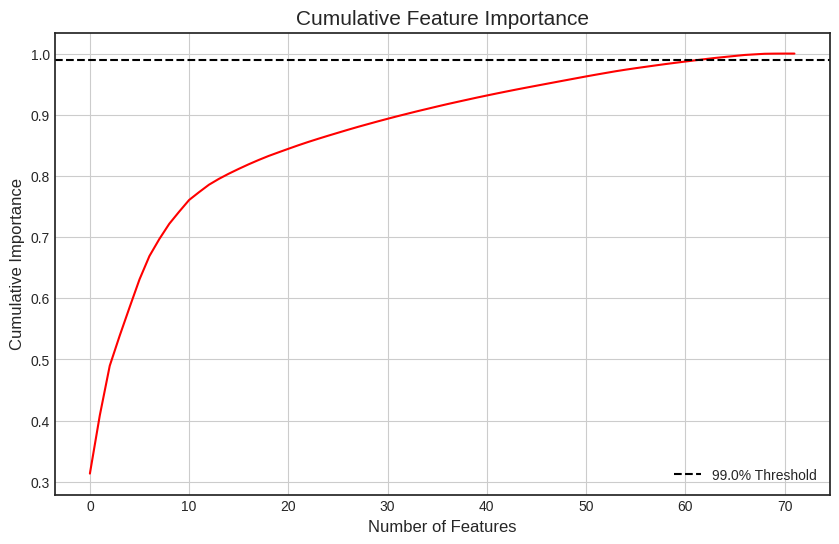

[GAIN] 분석 결과:
- 전체 피처 수: 72
- 99.0% 중요도를 설명하는 피처 수: 63
- 제거 추천 피처 수: 9
Low importance features :  ['city_avg_date_sales_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_12', 'item_cnt_month_lag_3', 'num_weekends', 'days', 'shop_type', 'type', 'is_new_on_shelf']


In [18]:
df_imp, keep_cols, low_cols = analyze_and_filter_features(final_lgbm_model, importance_type='gain', cum_threshold=0.99)
print('Low importance features : ', low_cols)

# Prediction

In [19]:
# final_preds = np.zeros(len(x_test))

# for model in model_list:
#     # log_preds = model.predict(x_test)
#     # preds = np.expm1(log_preds).clip(0, 20)
#     preds = model.predict(x_test).clip(0, 20)
#     final_preds += preds
    
# final_preds /= len(model_list)

In [20]:
final_preds = final_lgbm_model.predict(x_test).clip(0, 20)

In [21]:
test_chunk = all_data.loc[all_data['date_block_num'] == 34, ['shop_id', 'item_id']].copy()
test_chunk['item_cnt_month'] = final_preds

submission = pd.merge(test, test_chunk, on=['shop_id', 'item_id'], how='left')
submission['item_cnt_month'] = submission['item_cnt_month'].fillna(0)
submission[['ID', 'item_cnt_month']].to_csv(data_path + 'submssion_lgbm_model.csv', index=False)

In [22]:
submission['item_cnt_month'].isnull().sum()

0

In [23]:
print(pd.Series(final_preds).describe())

count    214200.000000
mean          0.271448
std           0.803859
min           0.000000
25%           0.017497
50%           0.075014
75%           0.232771
max          20.000000
dtype: float64


In [24]:
submission.head(10)

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.635023
1,1,5,5320,0.337302
2,2,5,5233,0.973567
3,3,5,5232,0.778881
4,4,5,5268,5.263614
5,5,5,5039,0.680160
6,6,5,5041,0.315721
7,7,5,5046,0.186679
8,8,5,5319,1.046177
9,9,5,5003,0.281092


In [25]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/submssion_lgbm_model.csv" -m "05_07_submssion_v5"

100%|██████████████████████████████████████| 5.05M/5.05M [00:00<00:00, 10.3MB/s]
Successfully submitted to Predict Future Sales